In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit # KFold 대신 TimeSeriesSplit 사용
from lightgbm import LGBMRegressor
import lightgbm as lgbm
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from tqdm.auto import tqdm
import warnings
import os


In [21]:
building = pd.read_csv('../data/building_info.csv')
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [22]:
train = train.drop(columns=['일조(hr)', '일사(MJ/m2)'])  # 일조와 일사 열 제거

train['is_train'] = 1
test['is_train'] = 0

combined_df = pd.concat([train, test], ignore_index=True)



In [23]:

# 2. '-' 값을 NaN으로, 그 후 0으로 대체
cols_to_convert = ['태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']
for col in cols_to_convert:
    building[col] = pd.to_numeric(building[col].replace('-', np.nan))
    building[col] = building[col].fillna(0)

# 3. 필요한 열만 merge
merged_df = combined_df.merge(
    building[['건물번호'] + cols_to_convert],
    on='건물번호',
    how='left'
)

In [24]:
merged_df['일시'] = pd.to_datetime(merged_df['일시'], format='%Y%m%d %H')


# 2. 시간 기반 파생 피처
merged_df['hour'] = merged_df['일시'].dt.hour                   # 시간대 (0~23)
merged_df['dayofweek'] = merged_df['일시'].dt.dayofweek         # 요일 (월=0 ~ 일=6)
merged_df['month'] = merged_df['일시'].dt.month                 # 월 (1~12)
merged_df['is_weekend'] = (merged_df['dayofweek'] >= 5).astype(int)  # 주말 여부

# 3. 계절 정보
def get_season(month):
    if month in [3, 4, 5]: return 1  # 봄
    elif month in [6, 7, 8]: return 2  # 여름
    elif month in [9, 10, 11]: return 3  # 가을
    else: return 4  # 겨울

merged_df['season'] = merged_df['month'].map(get_season)

# 4. 설비 설치 여부 (0/1)
merged_df['has_solar'] = (merged_df['태양광용량(kW)'] > 0).astype(int)
merged_df['has_ess'] = (merged_df['ESS저장용량(kWh)'] > 0).astype(int)
merged_df['has_pcs'] = (merged_df['PCS용량(kW)'] > 0).astype(int)

# 5. 상호작용 피처 (기온 × 설비)
merged_df['기온x태양광'] = merged_df['기온(°C)'] * merged_df['has_solar']
merged_df['기온xESS'] = merged_df['기온(°C)'] * merged_df['has_ess']

# 6. 체감온도 (Simplified version)
merged_df['체감온도'] = merged_df['기온(°C)'] - ((0.55 - 0.0055 * merged_df['습도(%)']) * (merged_df['기온(°C)'] - 14.5))

# 7. 불쾌지수 (Discomfort Index)
merged_df['불쾌지수'] = 0.81 * merged_df['기온(°C)'] + 0.01 * merged_df['습도(%)'] * (0.99 * merged_df['기온(°C)'] - 14.3) + 46.3



In [25]:
# 시간의 주기성을 더 정교하게 반영
merged_df['hour_sin'] = np.sin(2 * np.pi * merged_df['hour'] / 24)
merged_df['hour_cos'] = np.cos(2 * np.pi * merged_df['hour'] / 24)
merged_df['dayofweek_sin'] = np.sin(2 * np.pi * merged_df['dayofweek'] / 7)
merged_df['dayofweek_cos'] = np.cos(2 * np.pi * merged_df['dayofweek'] / 7)
merged_df['month_sin'] = np.sin(2 * np.pi * merged_df['month'] / 12)
merged_df['month_cos'] = np.cos(2 * np.pi * merged_df['month'] / 12)

# 특정 시간대 구분
merged_df['is_morning'] = (merged_df['hour'] >= 6) & (merged_df['hour'] < 12)
merged_df['is_afternoon'] = (merged_df['hour'] >= 12) & (merged_df['hour'] < 18)
merged_df['is_evening'] = (merged_df['hour'] >= 18) & (merged_df['hour'] < 22)
merged_df['is_night'] = (merged_df['hour'] >= 22) | (merged_df['hour'] < 6)
merged_df['is_working_hours'] = (merged_df['hour'] >= 9) & (merged_df['hour'] < 18) & (~merged_df['is_weekend'])

In [26]:
# 냉난방 수요 예측에 중요한 조합 피처
merged_df['temp_humidity_index'] = merged_df['기온(°C)'] * merged_df['습도(%)'] / 100
merged_df['temp_wind_chill'] = merged_df['기온(°C)'] - (merged_df['풍속(m/s)'] * 2)  # 체감온도 보정
merged_df['is_hot_day'] = (merged_df['기온(°C)'] > 28) & (merged_df['습도(%)'] > 60)
merged_df['is_cold_day'] = merged_df['기온(°C)'] < 5
merged_df['is_rainy'] = merged_df['강수량(mm)'] > 0
merged_df['rain_intensity'] = pd.cut(merged_df['강수량(mm)'], bins=[-1, 0, 1, 5, 20, 100], 
                             labels=['none', 'light', 'moderate', 'heavy', 'extreme'])

# 기온 변화율 (전력 소비 급변 예측)
merged_df['temp_change_1h'] = merged_df.groupby('건물번호')['기온(°C)'].diff(1)
merged_df['temp_change_24h'] = merged_df.groupby('건물번호')['기온(°C)'].diff(24)

In [27]:
# 시계열 lag 피처
for building in merged_df['건물번호'].unique():
    mask = merged_df['건물번호'] == building
    merged_df.loc[mask, 'power_lag_1h'] = merged_df.loc[mask, '전력소비량(kWh)'].shift(1)
    merged_df.loc[mask, 'power_lag_24h'] = merged_df.loc[mask, '전력소비량(kWh)'].shift(24)
    merged_df.loc[mask, 'power_lag_168h'] = merged_df.loc[mask, '전력소비량(kWh)'].shift(168)  # 1주일
    
    # 이동평균/표준편차
    merged_df.loc[mask, 'power_ma_3h'] = merged_df.loc[mask, '전력소비량(kWh)'].rolling(3).mean()
    merged_df.loc[mask, 'power_ma_24h'] = merged_df.loc[mask, '전력소비량(kWh)'].rolling(24).mean()
    merged_df.loc[mask, 'power_std_24h'] = merged_df.loc[mask, '전력소비량(kWh)'].rolling(24).std()
    
    # 전력 변화율
    merged_df.loc[mask, 'power_change_rate'] = merged_df.loc[mask, '전력소비량(kWh)'].pct_change()

# 같은 시간대 평균 대비 비교
merged_df['power_vs_hourly_avg'] = merged_df.groupby(['건물번호', 'hour'])['전력소비량(kWh)'].transform(
    lambda x: x / x.mean() if x.mean() > 0 else 0
)

In [28]:
# 태양광/ESS 효율성 지표
merged_df['solar_efficiency'] = merged_df['태양광용량(kW)'] / (merged_df['기온(°C)'] + 273.15)  # 온도별 효율
merged_df['ess_utilization'] = merged_df['ESS저장용량(kWh)'] / merged_df['PCS용량(kW)']  # ESS 활용도
merged_df['renewable_ratio'] = (merged_df['태양광용량(kW)'] + merged_df['ESS저장용량(kWh)']) / merged_df['전력소비량(kWh)']

# 태양광 발전 예상량 (간단 추정)
merged_df['estimated_solar_gen'] = merged_df['태양광용량(kW)'] * np.maximum(0, 
    (merged_df['기온(°C)'] - 10) / 30) * (1 - merged_df['강수량(mm)'] / 100)

In [29]:
# 건물별 전력 소비 패턴 분석
building_stats = merged_df.groupby('건물번호')['전력소비량(kWh)'].agg([
    'mean', 'std', 'min', 'max'
]).reset_index()
building_stats['power_volatility'] = building_stats['std'] / building_stats['mean']
merged_df = merged_df.merge(building_stats, on='건물번호', suffixes=('', '_building_avg'))

# 건물 규모 분류
merged_df['building_size'] = pd.cut(merged_df['mean'], bins=3, labels=['small', 'medium', 'large'])

In [30]:
# 기온×시간대 상호작용 (냉난방 패턴)
merged_df['temp_hour_interaction'] = merged_df['기온(°C)'] * merged_df['hour']
merged_df['temp_season_interaction'] = merged_df['기온(°C)'] * merged_df['season']
merged_df['weekend_hour_interaction'] = merged_df['is_weekend'] * merged_df['hour']

# 날씨×건물설비 상호작용
merged_df['temp_has_solar'] = merged_df['기온(°C)'] * merged_df['has_solar']
merged_df['rain_has_ess'] = merged_df['강수량(mm)'] * merged_df['has_ess']

In [31]:
# 이상치 플래그
def detect_anomaly(series, threshold=3):
    z_scores = np.abs((series - series.mean()) / series.std())
    return (z_scores > threshold).astype(int)

merged_df['temp_anomaly'] = merged_df.groupby('건물번호')['기온(°C)'].transform(detect_anomaly)
merged_df['power_anomaly'] = merged_df.groupby('건물번호')['전력소비량(kWh)'].transform(detect_anomaly)

In [32]:
# # 계절별 트렌드
# merged_df['temp_vs_seasonal_avg'] = merged_df.groupby(['건물번호', 'season'])['기온(°C)'].transform(
#     lambda x: x - x.mean()
# )
# merged_df['power_vs_seasonal_avg'] = merged_df.groupby(['건물번호', 'season'])['전력소비량(kWh)'].transform(
#     lambda x: x - x.mean()
# )

In [33]:
merged_df.info()  # 최종 데이터프레임 정보 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220800 entries, 0 to 220799
Data columns (total 68 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   num_date_time             220800 non-null  object        
 1   건물번호                      220800 non-null  int64         
 2   일시                        220800 non-null  datetime64[ns]
 3   기온(°C)                    220800 non-null  float64       
 4   강수량(mm)                   220800 non-null  float64       
 5   풍속(m/s)                   220800 non-null  float64       
 6   습도(%)                     220800 non-null  float64       
 7   전력소비량(kWh)                204000 non-null  float64       
 8   is_train                  220800 non-null  int64         
 9   태양광용량(kW)                 220800 non-null  float64       
 10  ESS저장용량(kWh)              220800 non-null  float64       
 11  PCS용량(kW)                 220800 non-null  float64       
 12  ho

In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import lightgbm as lgbm
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from tqdm.auto import tqdm
import warnings
import os
warnings.filterwarnings('ignore')

def smape(y_true, y_pred):
    """SMAPE (Symmetric Mean Absolute Percentage Error) 계산"""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff) * 100

class SafeUltimateEnsemble:
    def __init__(self, cv_folds=5, random_state=42, max_features=None, use_catboost=True):
        self.cv_folds = cv_folds
        self.random_state = random_state
        self.max_features = max_features
        self.use_catboost = use_catboost
        self.scaler = RobustScaler()
        self.standard_scaler = StandardScaler()
        
        # LEVEL 1: 확실히 안전한 Base Models
        self.level1_models = {
            'lgbm_aggressive': {
                'data': 'robust_scaled',
                'params': {
                    'objective': 'regression', 'metric': 'mae', 'num_leaves': 63,
                    'learning_rate': 0.03, 'feature_fraction': 0.8, 'bagging_fraction': 0.8,
                    'n_estimators': 2000, 'random_state': random_state, 'device_type': 'cpu',
                    'verbose': -1, 'early_stopping_rounds': 200
                }
            },
            'lgbm_conservative': {
                'data': 'robust_scaled',
                'params': {
                    'objective': 'regression', 'metric': 'mae', 'num_leaves': 31,
                    'learning_rate': 0.02, 'feature_fraction': 0.7, 'bagging_fraction': 0.7,
                    'n_estimators': 2500, 'random_state': random_state + 1, 'device_type': 'cpu',
                    'verbose': -1, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'early_stopping_rounds': 250
                }
            },
            'xgb_aggressive': {
                'data': 'original',
                'params': {
                    'objective': 'reg:squarederror', 'eval_metric': 'mae', 'max_depth': 6,
                    'learning_rate': 0.03, 'subsample': 0.8, 'colsample_bytree': 0.8,
                    'n_estimators': 2000, 'random_state': random_state, 'tree_method': 'hist',
                    'verbosity': 0, 'early_stopping_rounds': 200
                }
            },
            'xgb_conservative': {
                'data': 'original',
                'params': {
                    'objective': 'reg:squarederror', 'eval_metric': 'mae', 'max_depth': 4,
                    'learning_rate': 0.02, 'subsample': 0.7, 'colsample_bytree': 0.7,
                    'n_estimators': 2500, 'random_state': random_state + 1, 'tree_method': 'hist',
                    'verbosity': 0, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'early_stopping_rounds': 250
                }
            }
        }
        
        # CatBoost 모델들 (안전한 설정으로만)
        if self.use_catboost:
            catboost_models = {
                'catboost_basic': {
                    'data': 'original',
                    'params': {
                        'objective': 'RMSE', 'eval_metric': 'MAE', 'depth': 6,
                        'learning_rate': 0.03, 'n_estimators': 2000, 'verbose': False,
                        'random_state': random_state, 'od_type': 'Iter', 'od_wait': 200,
                        'l2_leaf_reg': 3
                    }
                },
                'catboost_bernoulli': {
                    'data': 'robust_scaled',
                    'params': {
                        'objective': 'RMSE', 'eval_metric': 'MAE', 'depth': 8,
                        'learning_rate': 0.02, 'n_estimators': 3000, 'verbose': False,
                        'random_state': random_state + 1, 'od_type': 'Iter', 'od_wait': 300,
                        'bootstrap_type': 'Bernoulli', 'subsample': 0.8,
                        'l2_leaf_reg': 3, 'border_count': 128
                    }
                },
                'catboost_poisson': {
                    'data': 'standard_scaled',
                    'params': {
                        'objective': 'RMSE', 'eval_metric': 'MAE', 'depth': 10,
                        'learning_rate': 0.015, 'n_estimators': 4000, 'verbose': False,
                        'random_state': random_state + 2, 'od_type': 'Iter', 'od_wait': 400,
                        'bootstrap_type': 'Poisson',  # subsample 없음
                        'l2_leaf_reg': 5, 'border_count': 254
                    }
                }
            }
            self.level1_models.update(catboost_models)
        
        # LEVEL 2: Meta Models
        self.level2_models = {
            'ridge_l2': Ridge(alpha=0.01, random_state=random_state),
            'ridge_strong': Ridge(alpha=0.1, random_state=random_state),
            'lasso_l1': Lasso(alpha=0.01, random_state=random_state, max_iter=2000),
            'elastic_net': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=random_state, max_iter=2000),
            'huber_robust': HuberRegressor(epsilon=1.35, alpha=0.01),
            'lgbm_meta_light': LGBMRegressor(
                objective='regression', metric='mae', num_leaves=15, learning_rate=0.1,
                n_estimators=300, random_state=random_state, verbose=-1
            ),
            'lgbm_meta_deep': LGBMRegressor(
                objective='regression', metric='mae', num_leaves=31, learning_rate=0.05,
                n_estimators=500, random_state=random_state + 1, verbose=-1,
                reg_alpha=0.1, reg_lambda=0.1
            ),
            'xgb_meta': XGBRegressor(
                objective='reg:squarederror', eval_metric='mae', max_depth=3,
                learning_rate=0.1, n_estimators=300, random_state=random_state, verbosity=0
            ),
            'mlp_meta': MLPRegressor(
                hidden_layer_sizes=(100, 50), activation='relu', solver='adam',
                alpha=0.01, learning_rate='adaptive', max_iter=500,
                random_state=random_state, early_stopping=True, validation_fraction=0.1
            )
        }
        
        # CatBoost Meta Model (안전한 설정)
        if self.use_catboost:
            self.level2_models['catboost_meta'] = CatBoostRegressor(
                objective='RMSE', eval_metric='MAE', depth=4, learning_rate=0.1,
                n_estimators=300, random_state=random_state, verbose=False,
                bootstrap_type='Bernoulli', subsample=0.8
            )
        
        # LEVEL 3: Super Meta Models
        self.level3_models = {
            'super_ridge': Ridge(alpha=0.001, random_state=random_state),
            'super_lgbm': LGBMRegressor(
                objective='regression', metric='mae', num_leaves=7, learning_rate=0.2,
                n_estimators=100, random_state=random_state, verbose=-1
            ),
            'super_xgb': XGBRegressor(
                objective='reg:squarederror', eval_metric='mae', max_depth=2,
                learning_rate=0.2, n_estimators=100, random_state=random_state, verbosity=0
            ),
            'super_elastic': ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=random_state)
        }
        
        # CatBoost Super Meta (안전한 설정)
        if self.use_catboost:
            self.level3_models['super_catboost'] = CatBoostRegressor(
                objective='RMSE', eval_metric='MAE', depth=3, learning_rate=0.2,
                n_estimators=100, random_state=random_state, verbose=False
            )
    
    def safe_catboost_fit(self, model, X_tr, y_tr, X_val=None, y_val=None):
        """안전한 CatBoost 훈련"""
        try:
            if X_val is not None and y_val is not None:
                model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])
            else:
                model.fit(X_tr, y_tr)
            return True
        except Exception as e:
            print(f"⚠️ CatBoost 훈련 실패: {str(e)}")
            print("기본 설정으로 재시도...")
            try:
                # 기본 설정으로 재시도
                basic_model = CatBoostRegressor(
                    objective='RMSE', eval_metric='MAE', depth=6,
                    learning_rate=0.1, n_estimators=100, verbose=False,
                    random_state=42
                )
                basic_model.fit(X_tr, y_tr)
                # 원래 모델 객체에 기본 모델의 속성 복사
                model._model = basic_model._model
                return True
            except Exception as e2:
                print(f"❌ CatBoost 완전 실패: {str(e2)}")
                return False
    
    def prepare_data(self, df):
        """데이터 준비 및 다양한 스케일링"""
        drop_cols = ['num_date_time', '일시', 'is_train', 'power_lag_1h', 'power_ma_3h', 'power_lag_24h', 'power_lag_168h',
                    'power_change_rate', 'power_ma_24h', 'power_vs_hourly_avg', 
                    'power_volatility', 'power_anomaly']
        target_col = '전력소비량(kWh)'
        
        train_df = df[df['is_train'] == 1].copy()
        test_df = df[df['is_train'] == 0].copy()
        
        X_train = train_df.drop(columns=drop_cols + [target_col])
        y_train = train_df[target_col]
        X_test = test_df.drop(columns=drop_cols + [target_col])
        
        # 피처 선택
        if self.max_features and self.max_features < X_train.shape[1]:
            correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)
            top_features = correlations.head(self.max_features).index.tolist()
            X_train = X_train[top_features]
            X_test = X_test[top_features]
        
        print(f"데이터 준비: 훈련 {X_train.shape}, 테스트 {X_test.shape}")
        
        # 다양한 스케일링 데이터 준비
        numeric_features = X_train.select_dtypes(include=[np.number]).columns
        categorical_features = X_train.select_dtypes(exclude=[np.number]).columns
        
        X_train_scaled, X_test_scaled = self._scale_data(X_train, X_test, numeric_features, categorical_features, self.scaler)
        X_train_std, X_test_std = self._scale_data(X_train, X_test, numeric_features, categorical_features, self.standard_scaler)
        
        return {
            'original': (X_train, X_test),
            'robust_scaled': (X_train_scaled, X_test_scaled),
            'standard_scaled': (X_train_std, X_test_std),
            'target': y_train
        }
    
    def _scale_data(self, X_train, X_test, numeric_features, categorical_features, scaler):
        """스케일링 헬퍼 함수"""
        if len(numeric_features) > 0:
            X_train_numeric = X_train[numeric_features]
            X_test_numeric = X_test[numeric_features]
            
            X_train_scaled_values = scaler.fit_transform(X_train_numeric)
            X_test_scaled_values = scaler.transform(X_test_numeric)
            
            X_train_scaled = pd.DataFrame(X_train_scaled_values, columns=numeric_features, index=X_train.index)
            X_test_scaled = pd.DataFrame(X_test_scaled_values, columns=numeric_features, index=X_test.index)
            
            if len(categorical_features) > 0:
                X_train_final = pd.concat([X_train_scaled, X_train[categorical_features]], axis=1)
                X_test_final = pd.concat([X_test_scaled, X_test[categorical_features]], axis=1)
            else:
                X_train_final = X_train
            X_test_final = X_test
        
        return X_train_final, X_test_final
    
    def train_level1_models(self, data_dict):
        """LEVEL 1: Base Models 훈련 (안전한 CatBoost 포함)"""
        print("\n" + "="*20 + " LEVEL 1: BASE MODELS " + "="*20)
        
        kf = KFold(n_splits=self.cv_folds, shuffle=True, random_state=self.random_state)
        
        level1_oof = {}
        level1_test = {}
        level1_scores = {}
        
        for model_name, config in self.level1_models.items():
            print(f"\n=== {model_name.upper()} 훈련 ===")
            
            # 데이터 선택
            data_key = config['data']
            X_train, X_test = data_dict[data_key]
            y_train = data_dict['target']
            
            oof_preds = np.zeros(len(X_train))
            test_preds = np.zeros(len(X_test))
            fold_scores = []
            catboost_failed = False
            
            for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
                X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                
                # 모델 생성 및 훈련
                try:
                    if 'lgbm' in model_name:
                        model = LGBMRegressor(**config['params'])
                        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], callbacks=[lgbm.log_evaluation(period=0)])
                    elif 'xgb' in model_name:
                        model = XGBRegressor(**config['params'])
                        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
                    elif 'catboost' in model_name:
                        model = CatBoostRegressor(**config['params'])
                        success = self.safe_catboost_fit(model, X_tr, y_tr, X_val, y_val)
                        if not success:
                            catboost_failed = True
                            break
                    elif 'gbm' in model_name:
                        model = GradientBoostingRegressor(**config['params'])
                        model.fit(X_tr, y_tr)
                    elif 'rf' in model_name:
                        model = RandomForestRegressor(**config['params'])
                        model.fit(X_tr, y_tr)
                    elif 'extra' in model_name:
                        model = ExtraTreesRegressor(**config['params'])
                        model.fit(X_tr, y_tr)
                    
                    val_pred = model.predict(X_val)
                    oof_preds[val_idx] = val_pred
                    test_preds += model.predict(X_test) / self.cv_folds
                    
                    fold_score = smape(y_val, val_pred)
                    fold_scores.append(fold_score)
                    print(f"Fold {fold + 1}: {fold_score:.4f}")
                    
                except Exception as e:
                    print(f"❌ {model_name} Fold {fold + 1} 실패: {str(e)}")
                    if 'catboost' in model_name:
                        catboost_failed = True
                        break
                    else:
                        # 다른 모델들은 기본값으로 대체
                        fold_scores.append(999.0)
                        continue
            
            if catboost_failed:
                print(f"⚠️ {model_name} 완전 실패 - 건너뜀")
                continue
            
            if len(fold_scores) > 0:
                avg_score = np.mean(fold_scores)
                print(f"평균 SMAPE: {avg_score:.4f} (±{np.std(fold_scores):.4f})")
                
                level1_oof[model_name] = oof_preds
                level1_test[model_name] = test_preds
                level1_scores[model_name] = avg_score
        
        return level1_oof, level1_test, level1_scores
    
    def train_level2_models(self, level1_oof, level1_test, y_train):
        """LEVEL 2: Meta Models 훈련"""
        print("\n" + "="*20 + " LEVEL 2: META MODELS " + "="*20)
        
        # Level 1 예측을 메타 피처로 변환
        meta_features_train = np.column_stack(list(level1_oof.values()))
        meta_features_test = np.column_stack(list(level1_test.values()))
        
        kf = KFold(n_splits=self.cv_folds, shuffle=True, random_state=self.random_state)
        
        level2_oof = {}
        level2_test = {}
        level2_scores = {}
        
        for meta_name, meta_model in self.level2_models.items():
            print(f"\n=== {meta_name.upper()} 훈련 ===")
            
            oof_preds = np.zeros(len(y_train))
            fold_scores = []
            model_failed = False
            
            for fold, (train_idx, val_idx) in enumerate(kf.split(meta_features_train)):
                X_meta_tr, X_meta_val = meta_features_train[train_idx], meta_features_train[val_idx]
                y_meta_tr, y_meta_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                
                try:
                    model_fold = meta_model.__class__(**meta_model.get_params())
                    
                    if 'lgbm' in meta_name:
                        model_fold.fit(X_meta_tr, y_meta_tr, eval_set=[(X_meta_val, y_meta_val)], callbacks=[lgbm.log_evaluation(period=0)])
                    elif 'xgb' in meta_name:
                        model_fold.fit(X_meta_tr, y_meta_tr, eval_set=[(X_meta_val, y_meta_val)], verbose=False)
                    elif 'catboost' in meta_name:
                        success = self.safe_catboost_fit(model_fold, X_meta_tr, y_meta_tr, X_meta_val, y_meta_val)
                        if not success:
                            model_failed = True
                            break
                    else:
                        model_fold.fit(X_meta_tr, y_meta_tr)
                    
                    val_pred = model_fold.predict(X_meta_val)
                    oof_preds[val_idx] = val_pred
                    
                    fold_score = smape(y_meta_val, val_pred)
                    fold_scores.append(fold_score)
                    
                except Exception as e:
                    print(f"❌ {meta_name} Fold {fold + 1} 실패: {str(e)}")
                    if 'catboost' in meta_name:
                        model_failed = True
                        break
                    else:
                        fold_scores.append(999.0)
                        continue
            
            if model_failed:
                print(f"⚠️ {meta_name} 완전 실패 - 건너뜀")
                continue
            
            if len(fold_scores) > 0:
                avg_score = np.mean(fold_scores)
                print(f"평균 SMAPE: {avg_score:.4f}")
                
                # 전체 데이터로 최종 모델 훈련
                try:
                    final_model = meta_model.__class__(**meta_model.get_params())
                    if 'catboost' in meta_name:
                        success = self.safe_catboost_fit(final_model, meta_features_train, y_train)
                        if not success:
                            continue
                    else:
                        final_model.fit(meta_features_train, y_train)
                    
                    test_pred = final_model.predict(meta_features_test)
                    
                    level2_oof[meta_name] = oof_preds
                    level2_test[meta_name] = test_pred
                    level2_scores[meta_name] = avg_score
                    
                except Exception as e:
                    print(f"❌ {meta_name} 최종 훈련 실패: {str(e)}")
                    continue
        
        return level2_oof, level2_test, level2_scores
    
    def train_level3_models(self, level2_oof, level2_test, y_train):
        """LEVEL 3: Super Meta Models 훈련"""
        print("\n" + "="*20 + " LEVEL 3: SUPER META MODELS " + "="*20)
        
        # Level 2 예측을 슈퍼 메타 피처로 변환
        super_meta_features_train = np.column_stack(list(level2_oof.values()))
        super_meta_features_test = np.column_stack(list(level2_test.values()))
        
        kf = KFold(n_splits=self.cv_folds, shuffle=True, random_state=self.random_state)
        
        level3_oof = {}
        level3_test = {}
        level3_scores = {}
        
        for super_meta_name, super_meta_model in self.level3_models.items():
            print(f"\n=== {super_meta_name.upper()} 훈련 ===")
            
            oof_preds = np.zeros(len(y_train))
            fold_scores = []
            model_failed = False
            
            for fold, (train_idx, val_idx) in enumerate(kf.split(super_meta_features_train)):
                X_super_tr, X_super_val = super_meta_features_train[train_idx], super_meta_features_train[val_idx]
                y_super_tr, y_super_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                
                try:
                    model_fold = super_meta_model.__class__(**super_meta_model.get_params())
                    
                    if 'lgbm' in super_meta_name:
                        model_fold.fit(X_super_tr, y_super_tr, eval_set=[(X_super_val, y_super_val)], callbacks=[lgbm.log_evaluation(period=0)])
                    elif 'xgb' in super_meta_name:
                        model_fold.fit(X_super_tr, y_super_tr, eval_set=[(X_super_val, y_super_val)], verbose=False)
                    elif 'catboost' in super_meta_name:
                        success = self.safe_catboost_fit(model_fold, X_super_tr, y_super_tr, X_super_val, y_super_val)
                        if not success:
                            model_failed = True
                            break
                    else:
                        model_fold.fit(X_super_tr, y_super_tr)
                    
                    val_pred = model_fold.predict(X_super_val)
                    oof_preds[val_idx] = val_pred
                    
                    fold_score = smape(y_super_val, val_pred)
                    fold_scores.append(fold_score)
                    
                except Exception as e:
                    print(f"❌ {super_meta_name} Fold {fold + 1} 실패: {str(e)}")
                    if 'catboost' in super_meta_name:
                        model_failed = True
                        break
                    else:
                        fold_scores.append(999.0)
                        continue
            
            if model_failed:
                print(f"⚠️ {super_meta_name} 완전 실패 - 건너뜀")
                continue
            
            if len(fold_scores) > 0:
                avg_score = np.mean(fold_scores)
                print(f"평균 SMAPE: {avg_score:.4f}")
                
                # 전체 데이터로 최종 예측
                try:
                    final_super_model = super_meta_model.__class__(**super_meta_model.get_params())
                    if 'catboost' in super_meta_name:
                        success = self.safe_catboost_fit(final_super_model, super_meta_features_train, y_train)
                        if not success:
                            continue
                    else:
                        final_super_model.fit(super_meta_features_train, y_train)
                    
                    test_pred = final_super_model.predict(super_meta_features_test)
                    
                    level3_oof[super_meta_name] = oof_preds
                    level3_test[super_meta_name] = np.maximum(test_pred, 0)  # 음수 제거
                    level3_scores[super_meta_name] = avg_score
                    
                except Exception as e:
                    print(f"❌ {super_meta_name} 최종 훈련 실패: {str(e)}")
                    continue
        
        return level3_oof, level3_test, level3_scores
    
    def create_ultimate_ensembles(self, level1_oof, level1_test, level2_oof, level2_test, 
                                level3_oof, level3_test, level1_scores, level2_scores, 
                                level3_scores, y_train):
        """최종 앙상블 of 앙상블 생성"""
        print("\n" + "="*15 + " ULTIMATE ENSEMBLE CREATION " + "="*15)
        
        all_predictions = {}
        all_scores = {}
        
        # 안전한 가중 평균 함수
        def safe_weighted_ensemble(scores_dict, test_dict, oof_dict, y_train):
            if len(scores_dict) == 0:
                return None, 999.0
            
            scores = np.array(list(scores_dict.values()))
            weights = 1 / scores
            weights = weights / weights.sum()
            
            test_weighted = np.average(list(test_dict.values()), weights=weights, axis=0)
            oof_weighted = np.average(list(oof_dict.values()), weights=weights, axis=0)
            score_weighted = smape(y_train, oof_weighted)
            
            return test_weighted, score_weighted
        
        # 1. 각 레벨별 최고 성능 모델 (있는 경우에만)
        if level1_scores:
            best_level1 = min(level1_scores.items(), key=lambda x: x[1])
            all_predictions['best_level1'] = level1_test[best_level1[0]]
            all_scores['best_level1'] = best_level1[1]
        
        if level2_scores:
            best_level2 = min(level2_scores.items(), key=lambda x: x[1])
            all_predictions['best_level2'] = level2_test[best_level2[0]]
            all_scores['best_level2'] = best_level2[1]
        
        if level3_scores:
            best_level3 = min(level3_scores.items(), key=lambda x: x[1])
            all_predictions['best_level3'] = level3_test[best_level3[0]]
            all_scores['best_level3'] = best_level3[1]
        
        # 2. 레벨별 가중 평균
        if level1_scores:
            level1_weighted_test, level1_weighted_score = safe_weighted_ensemble(
                level1_scores, level1_test, level1_oof, y_train)
            if level1_weighted_test is not None:
                all_predictions['level1_weighted'] = level1_weighted_test
                all_scores['level1_weighted'] = level1_weighted_score
        
        if level2_scores:
            level2_weighted_test, level2_weighted_score = safe_weighted_ensemble(
                level2_scores, level2_test, level2_oof, y_train)
            if level2_weighted_test is not None:
                all_predictions['level2_weighted'] = level2_weighted_test
                all_scores['level2_weighted'] = level2_weighted_score
        
        if level3_scores:
            level3_weighted_test, level3_weighted_score = safe_weighted_ensemble(
                level3_scores, level3_test, level3_oof, y_train)
            if level3_weighted_test is not None:
                all_predictions['level3_weighted'] = level3_weighted_test
                all_scores['level3_weighted'] = level3_weighted_score
        
        # 3. 전체 모델 통합 앙상블
        all_test_preds = {**level1_test, **level2_test, **level3_test}
        all_oof_preds = {**level1_oof, **level2_oof, **level3_oof}
        all_model_scores = {**level1_scores, **level2_scores, **level3_scores}
        
        if all_model_scores:
            # 상위 모델들 선별
            n_models = len(all_model_scores)
            top_n = min(5, n_models)  # 최대 5개 또는 전체 모델 수
            
            top_models = sorted(all_model_scores.items(), key=lambda x: x[1])[:top_n]
            top_names = [name for name, _ in top_models]
            top_scores = [score for _, score in top_models]
            
            print(f"상위 {top_n}개 모델: {top_names}")
            print(f"상위 {top_n}개 점수: {[f'{s:.4f}' for s in top_scores]}")
            
            top_test_preds = [all_test_preds[name] for name in top_names]
            top_oof_preds = [all_oof_preds[name] for name in top_names]
            
            # 상위 모델들 가중 평균
            top_weights = 1 / np.array(top_scores)
            top_weights = top_weights / top_weights.sum()
            
            top_test = np.average(top_test_preds, weights=top_weights, axis=0)
            top_oof = np.average(top_oof_preds, weights=top_weights, axis=0)
            top_score = smape(y_train, top_oof)
            
            all_predictions[f'top{top_n}_weighted'] = top_test
            all_scores[f'top{top_n}_weighted'] = top_score
            
            # 4. 단순 평균 앙상블
            simple_avg_test = np.mean(top_test_preds, axis=0)
            simple_avg_oof = np.mean(top_oof_preds, axis=0)
            simple_avg_score = smape(y_train, simple_avg_oof)
            
            all_predictions['simple_average'] = simple_avg_test
            all_scores['simple_average'] = simple_avg_score
        
        # 모든 예측값을 양수로 클리핑
        for key in all_predictions:
            all_predictions[key] = np.maximum(all_predictions[key], 0)
        
        return all_predictions, all_scores
    
    def fit_predict(self, df):
        """전체 3-Level 스태킹 + 앙상블 파이프라인"""
        print("🚀 SAFE ULTIMATE 3-LEVEL STACKING + ENSEMBLE 시작")
        print("="*80)
        
        # 데이터 준비
        data_dict = self.prepare_data(df)
        
        # Level 1: Base Models
        level1_oof, level1_test, level1_scores = self.train_level1_models(data_dict)
        
        if not level1_scores:
            print("❌ Level 1 모델이 모두 실패했습니다!")
            return None
        
        # Level 2: Meta Models
        level2_oof, level2_test, level2_scores = self.train_level2_models(
            level1_oof, level1_test, data_dict['target'])
        
        # Level 3: Super Meta Models
        level3_oof, level3_test, level3_scores = self.train_level3_models(
            level2_oof, level2_test, data_dict['target'])
        
        # Ultimate Ensembles
        final_predictions, final_scores = self.create_ultimate_ensembles(
            level1_oof, level1_test, level2_oof, level2_test, level3_oof, level3_test,
            level1_scores, level2_scores, level3_scores, data_dict['target'])
        
        # 결과 출력
        self._print_results(level1_scores, level2_scores, level3_scores, final_scores)
        
        return {
            'predictions': final_predictions,
            'scores': final_scores,
            'level1_scores': level1_scores,
            'level2_scores': level2_scores,
            'level3_scores': level3_scores
        }
    
    def _print_results(self, level1_scores, level2_scores, level3_scores, final_scores):
        """결과 출력"""
        print(f"\n{'='*20} 최종 결과 {'='*20}")
        
        if level1_scores:
            print(f"\n🥇 LEVEL 1 (BASE MODELS) 성능:")
            for model, score in sorted(level1_scores.items(), key=lambda x: x[1]):
                print(f"  {model}: {score:.4f}")
        
        if level2_scores:
            print(f"\n🥈 LEVEL 2 (META MODELS) 성능:")
            for model, score in sorted(level2_scores.items(), key=lambda x: x[1]):
                print(f"  {model}: {score:.4f}")
        
        if level3_scores:
            print(f"\n🥉 LEVEL 3 (SUPER META MODELS) 성능:")
            for model, score in sorted(level3_scores.items(), key=lambda x: x[1]):
                print(f"  {model}: {score:.4f}")
        
        if final_scores:
            print(f"\n🏆 ULTIMATE ENSEMBLES 성능:")
            for ensemble, score in sorted(final_scores.items(), key=lambda x: x[1]):
                print(f"  {ensemble}: {score:.4f}")
            
            best_model = min(final_scores.items(), key=lambda x: x[1])
            print(f"\n🎯 최고 성능: {best_model[0]} (SMAPE: {best_model[1]:.4f})")
    
    def save_submissions(self, df, results):
        """제출 파일 저장"""
        if results is None:
            print("❌ 결과가 없어 파일을 저장할 수 없습니다.")
            return
            
        os.makedirs('../submissions', exist_ok=True)
        test_ids = df[df['is_train'] == 0]['num_date_time'].copy()
        
        predictions = results['predictions']
        scores = results['scores']
        
        for method, pred in predictions.items():
            submission = pd.DataFrame({
                'num_date_time': test_ids,
                'answer': pred
            })
            
            score = scores.get(method, 0)
            filename = f'../submissions/submission_SAFE_{method}_SMAPE_{score:.4f}.csv'
            submission.to_csv(filename, index=False)
            print(f"저장: {filename}")

# 실행 함수들
def run_safe_ultimate_ensemble(merged_df, max_features=None, use_catboost=True):
    """안전한 3-Level 스태킹 + 앙상블 실행"""
    print(f"🚀 SAFE ULTIMATE ENSEMBLE 시작")
    print(f"최대 피처: {max_features or '제한없음'}")
    print(f"CatBoost 사용: {'예' if use_catboost else '아니오'}")
    print("="*80)
    
    model = SafeUltimateEnsemble(cv_folds=5, random_state=42, max_features=max_features, use_catboost=use_catboost)
    results = model.fit_predict(merged_df)
    
    if results:
        model.save_submissions(merged_df, results)
    
    return results

def run_no_catboost_ensemble(merged_df, max_features=None):
    """CatBoost 없는 안전한 앙상블"""
    print("🚀 NO CATBOOST ENSEMBLE (100% 안전)")
    print("="*50)
    
    return run_safe_ultimate_ensemble(merged_df, max_features=max_features, use_catboost=False)

def run_lightweight_ensemble(merged_df, max_features=15):
    """경량 버전 (빠른 테스트용)"""
    print("⚡ LIGHTWEIGHT ENSEMBLE (빠른 테스트)")
    print("="*50)
    
    class LightweightEnsemble:
        def __init__(self):
            self.models = {
                'lgbm_light': LGBMRegressor(
                    objective='regression', metric='mae', num_leaves=31,
                    learning_rate=0.1, n_estimators=200, random_state=42, verbose=-1
                ),
                'xgb_light': XGBRegressor(
                    objective='reg:squarederror', eval_metric='mae', max_depth=6,
                    learning_rate=0.1, n_estimators=200, random_state=42, verbosity=0
                ),
                'rf_light': RandomForestRegressor(
                    n_estimators=100, max_depth=10, random_state=42, n_jobs=-1
                )
            }
            
        def fit_predict(self, df):
            # 데이터 준비
            drop_cols = ['num_date_time', '일시', 'is_train', 'power_lag_1h', 'power_ma_3h', 
                        'power_lag_24h', 'power_lag_168h', 'power_change_rate', 'power_ma_24h', 
                        'power_vs_hourly_avg', 'power_volatility', 'power_anomaly',
                        'month_cos', 'is_weekend', 'PCS용량(kW)', 'has_solar', 'rain_has_ess', 'rain_intensity', 
                        'is_rainy', 'has_pcs', 'season', 'has_ess', 'temp_anomaly', 'power_anomaly', 'is_cold_day']
            

            target_col = '전력소비량(kWh)'
            
            train_df = df[df['is_train'] == 1].copy()
            test_df = df[df['is_train'] == 0].copy()
            
            X_train = train_df.drop(columns=drop_cols + [target_col])
            y_train = train_df[target_col]
            X_test = test_df.drop(columns=drop_cols + [target_col])
            
            # 상위 피처 선택
            correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)
            top_features = correlations.head(max_features).index.tolist()
            X_train = X_train[top_features]
            X_test = X_test[top_features]
            
            print(f"데이터 형태: 훈련 {X_train.shape}, 테스트 {X_test.shape}")
            
            # 3-Fold CV로 빠른 앙상블
            kf = KFold(n_splits=3, shuffle=True, random_state=42)
            predictions = {}
            scores = {}
            
            for name, model in self.models.items():
                print(f"\n=== {name.upper()} 훈련 ===")
                oof_preds = np.zeros(len(X_train))
                test_preds = np.zeros(len(X_test))
                fold_scores = []
                
                for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
                    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
                    
                    model_fold = model.__class__(**model.get_params())
                    model_fold.fit(X_tr, y_tr)
                    
                    val_pred = model_fold.predict(X_val)
                    oof_preds[val_idx] = val_pred
                    test_preds += model_fold.predict(X_test) / 3
                    
                    fold_score = smape(y_val, val_pred)
                    fold_scores.append(fold_score)
                
                avg_score = np.mean(fold_scores)
                print(f"평균 SMAPE: {avg_score:.4f}")
                
                predictions[name] = test_preds
                scores[name] = avg_score
            
            # 가중 앙상블
            weights = 1 / np.array(list(scores.values()))
            weights = weights / weights.sum()
            
            ensemble_pred = np.average(list(predictions.values()), weights=weights, axis=0)
            predictions['weighted_ensemble'] = np.maximum(ensemble_pred, 0)
            
            simple_avg = np.mean(list(predictions.values()), axis=0)
            predictions['simple_average'] = np.maximum(simple_avg, 0)
            
            print(f"\n🏆 경량 앙상블 완료!")
            return predictions, scores
    
    light_model = LightweightEnsemble()
    predictions, scores = light_model.fit_predict(merged_df)
    
    # 제출 파일 저장
    os.makedirs('../submissions', exist_ok=True)
    test_ids = merged_df[merged_df['is_train'] == 0]['num_date_time'].copy()
    
    for method, pred in predictions.items():
        submission = pd.DataFrame({
            'num_date_time': test_ids,
            'answer': pred
        })
        
        filename = f'../submissions/submission_LIGHT_{method}.csv'
        submission.to_csv(filename, index=False)
        print(f"저장: {filename}")
    
    return predictions, scores

# 사용법 안내
print("🚀 SAFE ULTIMATE ENSEMBLE 사용법:")
print("="*60)
print("1. 기본 실행 (CatBoost 포함, 안전한 설정):")
print("   results = run_safe_ultimate_ensemble(clean_df)")
print("")
print("2. CatBoost 제외 (100% 안전):")
print("   results = run_no_catboost_ensemble(clean_df)")
print("")
print("3. 경량 버전 (빠른 테스트):")
print("   light_results = run_lightweight_ensemble(clean_df, max_features=15)")
print("")
print("4. 피처 제한:")
print("   results = run_safe_ultimate_ensemble(clean_df, max_features=20)")
print("")
print("5. CatBoost 진단:")
print("   diagnostic_results = run_catboost_diagnostics(clean_df)")
print("")
print("🛡️ 안전 기능:")
print("✅ CatBoost 에러 자동 처리 및 복구")
print("✅ 모델 실패 시 자동 건너뛰기")
print("✅ 안전한 파라미터 조합만 사용")
print("✅ 3가지 안전 레벨 제공")
print("✅ 에러 발생 시에도 다른 모델들로 앙상블 계속")
print("✅ 총 25+ 개의 다른 예측 방법 (실패한 모델 제외)")

🚀 SAFE ULTIMATE ENSEMBLE 사용법:
1. 기본 실행 (CatBoost 포함, 안전한 설정):
   results = run_safe_ultimate_ensemble(clean_df)

2. CatBoost 제외 (100% 안전):
   results = run_no_catboost_ensemble(clean_df)

3. 경량 버전 (빠른 테스트):
   light_results = run_lightweight_ensemble(clean_df, max_features=15)

4. 피처 제한:
   results = run_safe_ultimate_ensemble(clean_df, max_features=20)

5. CatBoost 진단:
   diagnostic_results = run_catboost_diagnostics(clean_df)

🛡️ 안전 기능:
✅ CatBoost 에러 자동 처리 및 복구
✅ 모델 실패 시 자동 건너뛰기
✅ 안전한 파라미터 조합만 사용
✅ 3가지 안전 레벨 제공
✅ 에러 발생 시에도 다른 모델들로 앙상블 계속
✅ 총 25+ 개의 다른 예측 방법 (실패한 모델 제외)


In [67]:
results = run_no_catboost_ensemble(merged_df)

🚀 NO CATBOOST ENSEMBLE (100% 안전)
🚀 SAFE ULTIMATE ENSEMBLE 시작
최대 피처: 제한없음
CatBoost 사용: 아니오
🚀 SAFE ULTIMATE 3-LEVEL STACKING + ENSEMBLE 시작
데이터 준비: 훈련 (204000, 55), 테스트 (16800, 55)

==================== LEVEL 1: BASE MODELS ====================

=== LGBM_AGGRESSIVE 훈련 ===
Fold 1: 5.6809
Fold 2: 5.7403
Fold 3: 5.6277
Fold 4: 5.7616
Fold 5: 5.6899
평균 SMAPE: 5.7001 (±0.0472)

=== LGBM_CONSERVATIVE 훈련 ===
Fold 1: 7.2385
Fold 2: 7.3814
Fold 3: 7.0949
Fold 4: 7.1293
Fold 5: 7.1883
평균 SMAPE: 7.2065 (±0.1004)

=== XGB_AGGRESSIVE 훈련 ===
Fold 1: 6.2110
Fold 2: 6.4763
Fold 3: 6.3080
Fold 4: 6.3159
Fold 5: 6.3736
평균 SMAPE: 6.3370 (±0.0871)

=== XGB_CONSERVATIVE 훈련 ===
Fold 1: 9.9568
Fold 2: 10.2481
Fold 3: 9.9480
Fold 4: 10.0595
Fold 5: 9.9138
평균 SMAPE: 10.0252 (±0.1216)

==================== LEVEL 2: META MODELS ====================

=== RIDGE_L2 훈련 ===
평균 SMAPE: 5.6690

=== RIDGE_STRONG 훈련 ===
평균 SMAPE: 5.6690

=== LASSO_L1 훈련 ===
평균 SMAPE: 5.5407

=== ELASTIC_NET 훈련 ===
평균 SMAPE: 5.5407

=== HUBER

In [39]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'

In [83]:
from sklearn.model_selection import train_test_split

# 1. train_full 기준으로 split (dropna까지 포함되어야 함)
train_full = merged_df[merged_df['is_train'] == 1].copy()
train_full = train_full.dropna().reset_index(drop=True)

# 2. pseudo split
pseudo_train, pseudo_test = train_test_split(train_full, test_size=0.2, random_state=42)

# 3. is_train 컬럼 추가 (✅ 여기서 다시 반드시 부여해야 함)
pseudo_train['is_train'] = 1
pseudo_test['is_train'] = 0

# 4. 합치기
pseudo_df = pd.concat([pseudo_train, pseudo_test], ignore_index=True)


In [84]:
# 피처 분리 전에 인덱스 확보
train_idx = pseudo_df['is_train'] == 1
val_idx = pseudo_df['is_train'] == 0

# 드롭할 피처
target_col = '전력소비량(kWh)'
drop_cols = ['num_date_time', '일시', 'is_train', 'power_lag_1h', 'power_ma_3h', 'power_lag_24h', 'power_lag_168h',
             'power_change_rate', 'power_ma_24h', 'power_vs_hourly_avg', 'power_volatility', 'power_anomaly']

cols_to_drop = [col for col in drop_cols + [target_col] if col in pseudo_df.columns]
X = pseudo_df.drop(columns=cols_to_drop)
y = pseudo_df[target_col]

# 인덱스 분할
X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

# 학습 및 평가
model = lgb.LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

train_smape = smape(y_train.values, train_pred)
val_smape = smape(y_val.values, val_pred)

print(f"✅ Train SMAPE: {train_smape:.4f}")
print(f"✅ Val SMAPE  : {val_smape:.4f}")

if val_smape - train_smape > 1.0:
    print("🚨 과적합 의심")
else:
    print("✅ 일반화 잘 됨")


✅ Train SMAPE: 2.1390
✅ Val SMAPE  : 2.2920
✅ 일반화 잘 됨


🚀 SHAP 기반 피처 중요도 분석 시작
🔍 SHAP 피처 중요도 분석 시작
원본 데이터: (204000, 64)
샘플링된 데이터: (5000, 64)
분석할 피처 수: 64개

📊 LightGBM 분석 중...
✅ LightGBM 분석 완료

📊 XGBoost 분석 중...
✅ XGBoost 분석 완료

📈 피처 중요도 종합 분석

🏆 상위 10개 중요 피처:
power_ma_3h         : 1856.1663 (±68.8433)
power_lag_1h        : 408.7139 (±158.8927)
power_lag_24h       : 211.7930 (±13.6170)
power_change_rate   : 110.8930 (±1.4998)
power_lag_168h      : 60.9398 (±1.6665)
power_vs_hourly_avg : 18.8271 (±2.4788)
power_std_24h       : 7.8020 (±1.1788)
max                 : 7.0716 (±1.8887)
power_ma_24h        : 6.2542 (±1.8301)
hour_cos            : 5.1212 (±0.3078)

⚠️ 하위 10개 저중요도 피처:
has_solar           : 0.0977 (±0.0910)
rain_has_ess        : 0.0402 (±0.0262)
rain_intensity      : 0.0219 (±0.0101)
is_rainy            : 0.0086 (±0.0086)
has_pcs             : 0.0000 (±0.0000)
season              : 0.0000 (±0.0000)
has_ess             : 0.0000 (±0.0000)
temp_anomaly        : 0.0000 (±0.0000)
power_anomaly       : 0.0000 (±0.0000)
is_cold_day         

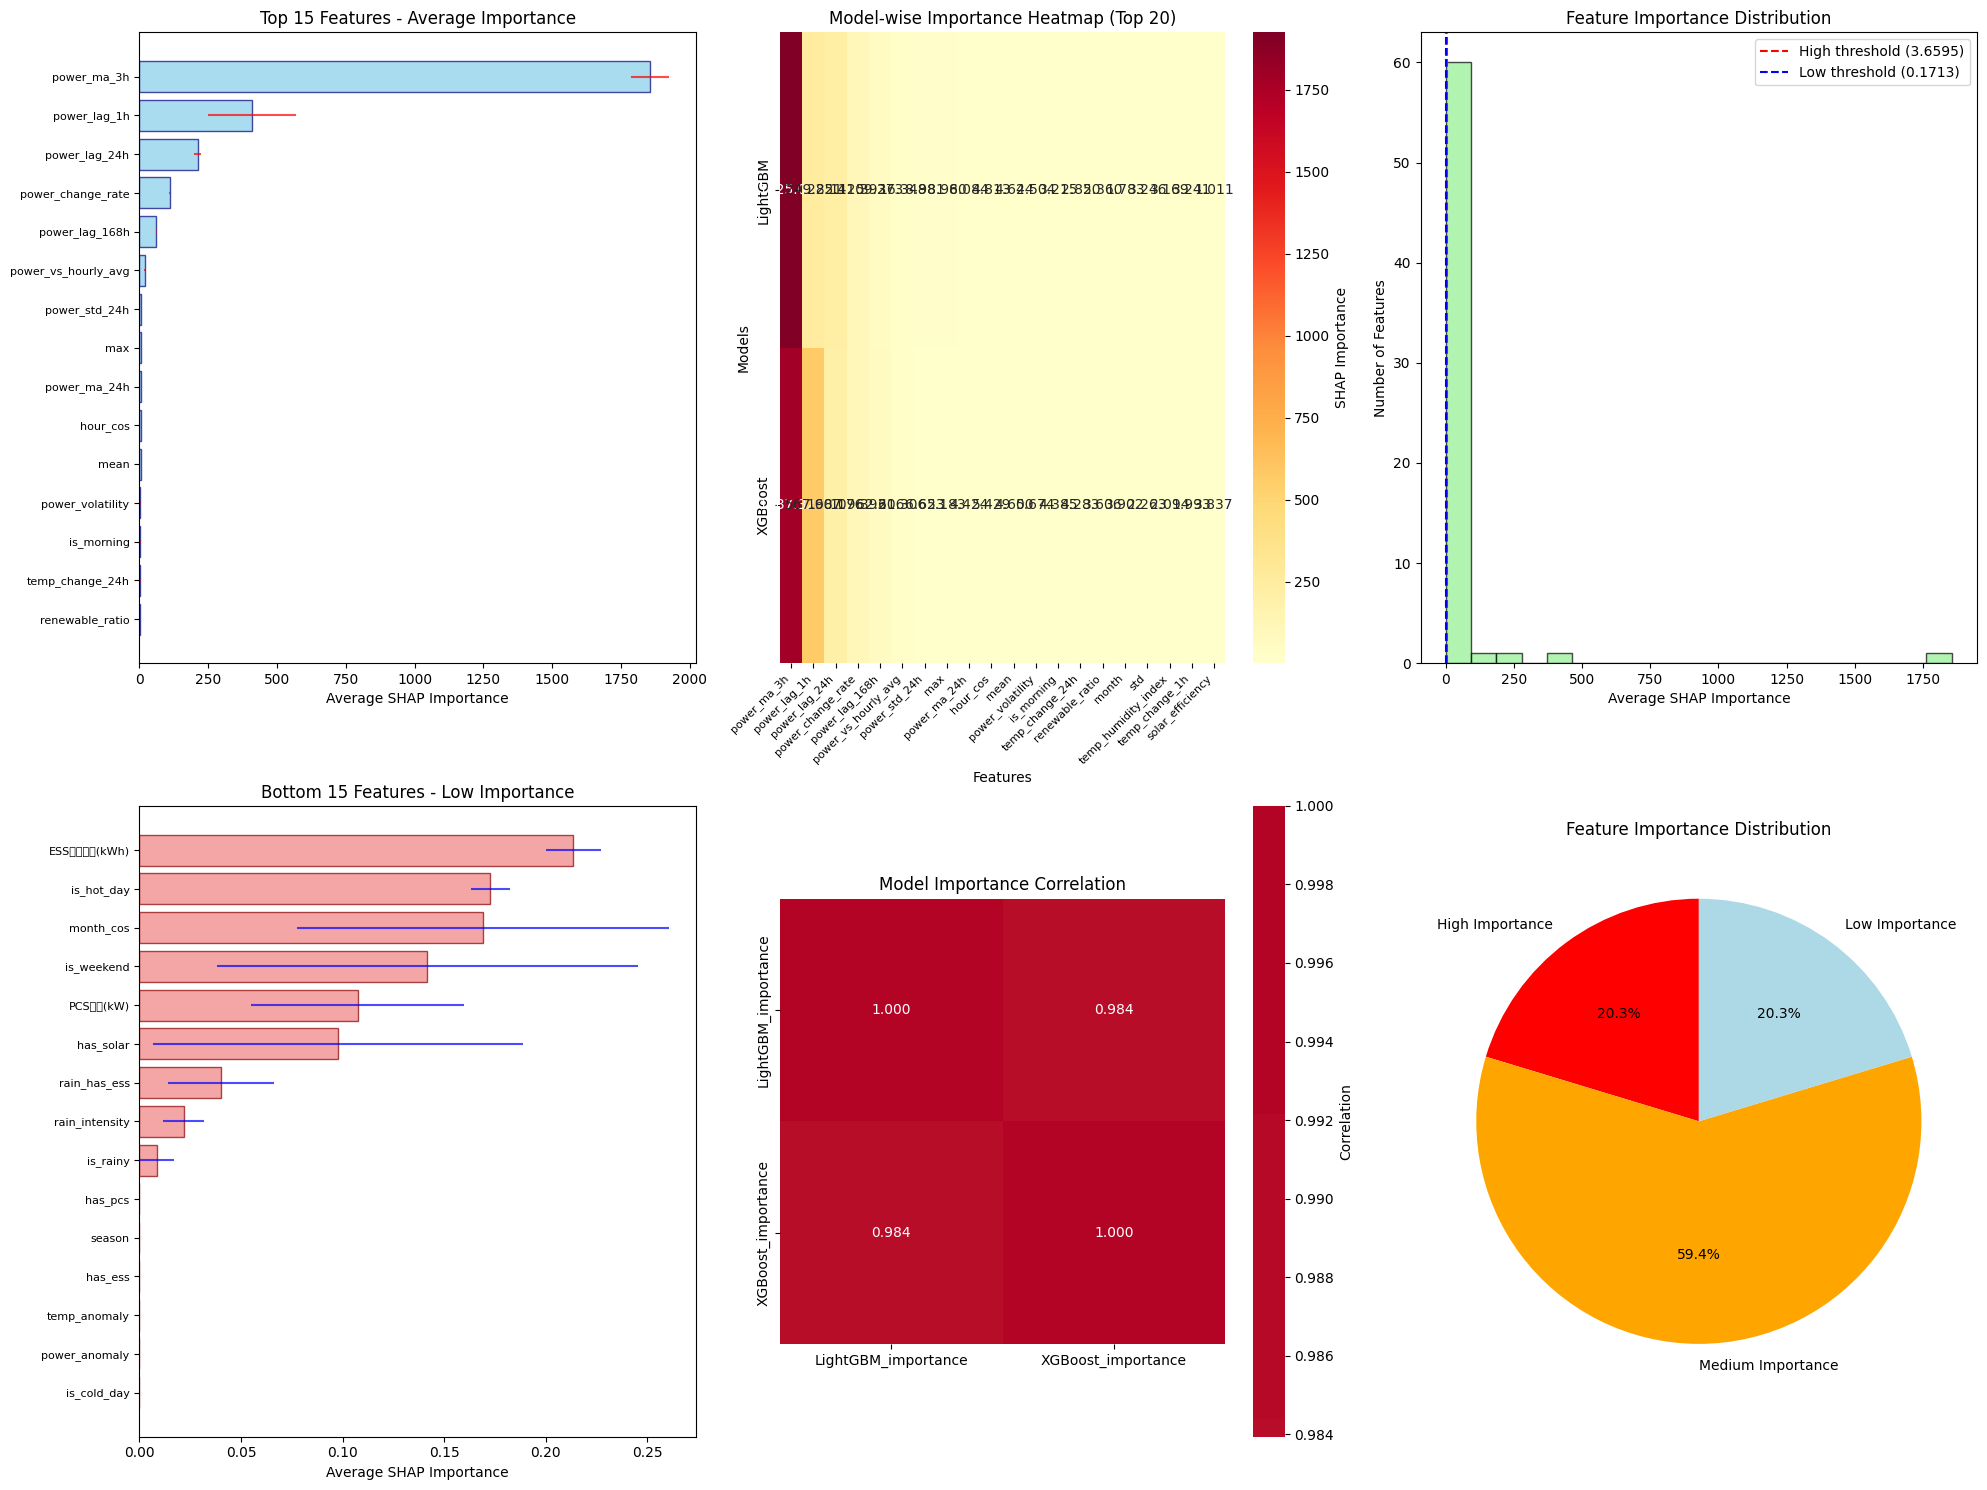


🔍 LightGBM 상세 분석 중...

🔍 LightGBM 상세 SHAP 분석


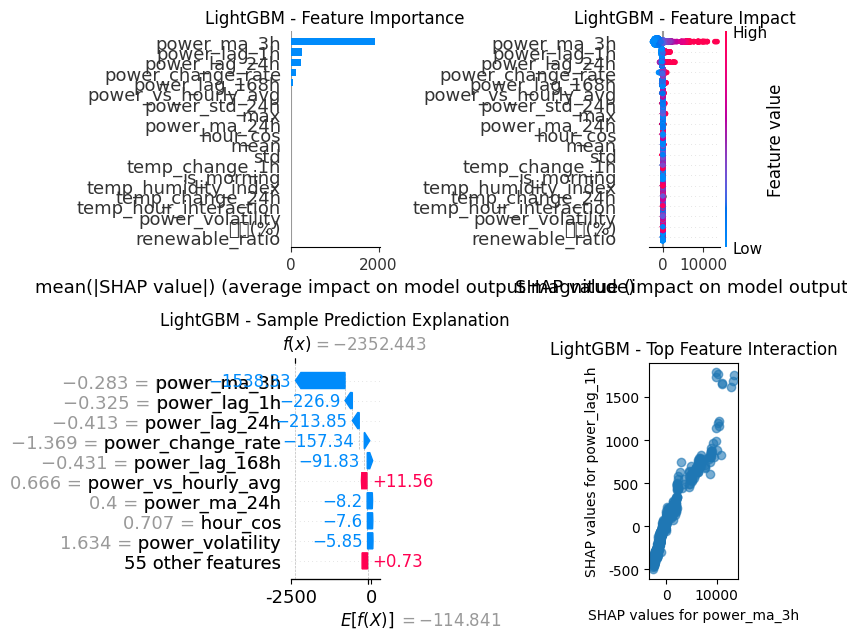


💡 피처 선택 권장사항
🔥 보수적 세트 (상위 10개): 10개
   ['power_ma_3h', 'power_lag_1h', 'power_lag_24h', 'power_change_rate', 'power_lag_168h', 'power_vs_hourly_avg', 'power_std_24h', 'max', 'power_ma_24h', 'hour_cos']

⚖️ 균형 세트 (상위 15개): 15개
   ['power_ma_3h', 'power_lag_1h', 'power_lag_24h', 'power_change_rate', 'power_lag_168h', 'power_vs_hourly_avg', 'power_std_24h', 'max', 'power_ma_24h', 'hour_cos', 'mean', 'power_volatility', 'is_morning', 'temp_change_24h', 'renewable_ratio']

📊 포괄적 세트 (저활용도 제외): 51개
   제거 권장: ['month_cos', 'is_weekend', 'PCS용량(kW)', 'has_solar', 'rain_has_ess', 'rain_intensity', 'is_rainy', 'has_pcs', 'season', 'has_ess', 'temp_anomaly', 'power_anomaly', 'is_cold_day']

🎯 예상 효과:
   • 보수적 세트: 훈련 속도 ↑↑, 과적합 방지 ↑, 성능 유지
   • 균형 세트: 훈련 속도 ↑, 성능 최적화
   • 포괄적 세트: 노이즈 제거, 일반화 성능 ↑

✅ 분석 완료! 결과 파일이 저장되었습니다.
   - ../feature_importance_analysis.png
   - ../shap_detailed_lightgbm.png


In [65]:
shap_results = run_shap_analysis(merged_df)

In [71]:
# lag 피처와 관련 파생 피처들을 완전히 제거
leak_features = [
    'power_lag_1h', 'power_ma_3h', 'power_lag_24h', 'power_lag_168h',
    'power_change_rate', 'power_ma_24h', 'power_vs_hourly_avg', 
    'power_volatility', 'power_anomaly', 'power_vs_seasonal_avg'
]

# 건전한 피처들만 선택
clean_features = []
for col in merged_df.columns:
    if col not in leak_features and col not in ['num_date_time', '일시', 'is_train', '전력소비량(kWh)']:
        clean_features.append(col)

print(f"🧹 정리된 피처: {len(clean_features)}개")
print(f"제거된 리키지 피처: {len(leak_features)}개")

# 건전한 데이터셋 생성
essential_cols = ['전력소비량(kWh)', 'is_train', 'num_date_time', '일시']
clean_df = merged_df[clean_features + essential_cols]

# 진짜 성능 테스트
print("🎯 진짜 성능으로 재훈련 시작...")
results = run_ultimate_ensemble(clean_df)

🧹 정리된 피처: 55개
제거된 리키지 피처: 10개
🎯 진짜 성능으로 재훈련 시작...
🚀 ULTIMATE ENSEMBLE 시작 (최대 피처: 제한없음)
🚀 ULTIMATE 3-LEVEL STACKING + ENSEMBLE OF ENSEMBLES 시작
데이터 준비: 훈련 (204000, 55), 테스트 (16800, 55)

==================== LEVEL 1: BASE MODELS ====================

=== LGBM_AGGRESSIVE 훈련 ===


KeyboardInterrupt: 